## 1. Setup and Imports

In [1]:
# Standard library imports
import sys
from pathlib import Path
from typing import Dict, List, Optional
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical analysis
from scipy.stats import linregress, norm as scipy_norm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Logging
from loguru import logger

# Configure matplotlib for notebook
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'DejaVu Sans'
%matplotlib inline

# Configure logger
logger.remove()
logger.add(
    sys.stdout,
    level="INFO",
    colorize=True,
    format="<green>{time:HH:mm:ss}</green> | <level>{message}</level>",
)

print("All packages imported successfully!")

All packages imported successfully!


## 2. Configure Paths and Data Sources

In [2]:
# Project paths
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
ORIGINAL_DATA = DATA_DIR / "original_data"

# Data sources
SOURCES = {
    "NASA_ONLY": DATA_DIR / "4_eto_nasa_only",
    "OPENMETEO_ONLY": DATA_DIR / "4_eto_openmeteo_only",
    "OPENMETEO_API": ORIGINAL_DATA / "eto_open_meteo",
    "EVAONLINE_FUSION": DATA_DIR / "6_validation_full_pipeline" / "xavier_validation" / "cache",
}

# Reference Xavier
XAVIER_DIR = ORIGINAL_DATA / "eto_xavier_csv"

# Output directory
OUTPUT_DIR = DATA_DIR / "analysis_results"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load city coordinates
csv_coords = PROJECT_ROOT / "data" / "info_cities.csv"
df_coords = pd.read_csv(csv_coords)

# City list (all 17 cities)
CITIES = df_coords['city'].tolist()

print(f"Data directories configured")
print(f"NASA POWER: {SOURCES['NASA_ONLY']}")
print(f"Open-Meteo: {SOURCES['OPENMETEO_ONLY']}")
print(f"Open-Meteo API: {SOURCES['OPENMETEO_API']}")
print(f"EVAonline Fusion: {SOURCES['EVAONLINE_FUSION']}")
print(f"Xavier Reference: {XAVIER_DIR}")
print(f"\nTotal cities to analyze: {len(CITIES)}")
print(f"Cities: {', '.join(CITIES[:5])}... (showing first 5)")

Data directories configured
NASA POWER: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\4_eto_nasa_only
Open-Meteo: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\4_eto_openmeteo_only
Open-Meteo API: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\original_data\eto_open_meteo
EVAonline Fusion: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\6_validation_full_pipeline\xavier_validation\cache
Xavier Reference: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\original_data\eto_xavier_csv

Total cities to analyze: 17
Cities: Alvorada_do_Gurgueia_PI, Araguaina_TO, Balsas_MA, Barreiras_BA, Bom_Jesus_PI... (showing first 5)


## 3. Data Loading Functions

In [3]:
def load_eto_data(city_name: str, source_key: str) -> Optional[pd.DataFrame]:
    """
    Load ETo data from a specific source.
    
    Args:
        city_name: City name
        source_key: Source key (NASA_ONLY, OPENMETEO_ONLY, etc)
    
    Returns:
        DataFrame with columns [date, eto]
    """
    source_dir = SOURCES[source_key]
    
    # Naming patterns by source
    patterns = {
        "NASA_ONLY": f"{city_name}_ETo_NASA_ONLY.csv",
        "OPENMETEO_ONLY": f"{city_name}_ETo_OpenMeteo_ONLY.csv",
        "OPENMETEO_API": f"{city_name}_OpenMeteo_ETo.csv",
        "EVAONLINE_FUSION": f"{city_name}_eto_final.csv",
    }
    
    file_path = source_dir / patterns[source_key]
    
    if not file_path.exists():
        return None
    
    try:
        df = pd.read_csv(file_path, parse_dates=["date"])
        
        # Rename ETo column for standardization
        eto_col_map = {
            "NASA_ONLY": "eto_evaonline",
            "OPENMETEO_ONLY": "eto_evaonline",
            "OPENMETEO_API": "eto_openmeteo",
            "EVAONLINE_FUSION": "eto_final",
        }
        
        eto_col = eto_col_map[source_key]
        
        if eto_col not in df.columns:
            return None
        
        df = df[["date", eto_col]].rename(columns={eto_col: "eto"})
        return df
        
    except Exception as e:
        return None


def load_xavier_reference(city_name: str) -> Optional[pd.DataFrame]:
    """Load Xavier reference data."""
    file_path = XAVIER_DIR / f"{city_name}.csv"
    
    if not file_path.exists():
        return None
    
    try:
        df = pd.read_csv(file_path, parse_dates=["date"])
        df = df[["date", "eto_xavier"]].rename(columns={"eto_xavier": "eto"})
        return df
    except Exception as e:
        return None

print("Data loading functions defined")

Data loading functions defined


## 4. Metrics Calculation Functions

In [4]:
def calculate_metrics(ref: np.ndarray, calc: np.ndarray) -> Dict[str, float]:
    """
    Calculate complete validation metrics.
    
    Returns:
        Dictionary with R², KGE, NSE, MAE, RMSE, PBIAS, etc.
    """
    # Force float and remove NaN
    ref = np.asarray(ref, dtype=float)
    calc = np.asarray(calc, dtype=float)
    mask = ~(np.isnan(ref) | np.isnan(calc))
    
    if mask.sum() < 10:
        return {k: np.nan for k in 'r2 kge nse mae rmse bias pbias slope intercept p_value'.split()}
    
    ref, calc = ref[mask], calc[mask]
    n = len(ref)
    
    # Basic metrics
    mae = float(mean_absolute_error(ref, calc))
    rmse = float(np.sqrt(mean_squared_error(ref, calc)))
    bias = float(np.mean(calc - ref))
    pbias = float(100 * np.sum(calc - ref) / np.sum(ref)) if np.sum(ref) != 0 else np.nan
    
    # Linear regression
    slope, intercept, r_val, p_val, _ = linregress(ref, calc)
    r2 = float(r_val**2)
    
    # NSE (Nash-Sutcliffe Efficiency)
    nse = float(1 - np.sum((calc - ref)**2) / np.sum((ref - ref.mean())**2))
    
    # KGE (Kling-Gupta Efficiency)
    r = np.corrcoef(ref, calc)[0, 1]
    alpha = np.std(calc) / np.std(ref) if np.std(ref) > 0 else np.nan
    beta = np.mean(calc) / np.mean(ref) if np.mean(ref) > 0 else np.nan
    kge = float(1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2))
    
    return {
        'n': int(n),
        'r2': round(r2, 3),
        'kge': round(kge, 3),
        'nse': round(nse, 3),
        'mae': round(mae, 3),
        'rmse': round(rmse, 3),
        'bias': round(bias, 3),
        'pbias': round(pbias, 2),
        'slope': round(float(slope), 3),
        'intercept': round(float(intercept), 3),
        'p_value': round(float(p_val), 6),
    }

print("Metrics calculation function defined")

Metrics calculation function defined


## 5. Load All Data for All Cities

This will load ETo data from all 4 sources + Xavier reference for all 17 cities.

In [5]:
# Dictionary to store all data: {city_name: {source_name: DataFrame}}
all_city_data = {}
source_labels = {
    'Xavier': 'BR-DWGD (reference)',
    'NASA_ONLY': 'NASA POWER only',
    'OPENMETEO_ONLY': 'Open-Meteo only',
    'OPENMETEO_API': 'Open-Meteo API',
    'EVAONLINE_FUSION': 'EVAonline Fusion',
}

print("Loading data for all cities...\n")

for i, city in enumerate(CITIES, 1):
    city_data = {}
    
    # Load Xavier reference
    df_xavier = load_xavier_reference(city)
    if df_xavier is None:
        print(f"[{i}/{len(CITIES)}] {city}: Xavier data not found")
        continue
    
    city_data['Xavier'] = df_xavier
    
    # Load all sources
    sources_loaded = 0
    for source_key in SOURCES.keys():
        df_source = load_eto_data(city, source_key)
        if df_source is not None:
            city_data[source_key] = df_source
            sources_loaded += 1
    
    if sources_loaded > 0:
        all_city_data[city] = city_data
        print(f"[{i}/{len(CITIES)}] {city}: {sources_loaded}/4 sources loaded (Xavier: {len(df_xavier)} days)")
    else:
        print(f"[{i}/{len(CITIES)}] {city}: No source data found")

print(f"\nData loaded for {len(all_city_data)} cities")
print(f"Total cities with complete data: {len(all_city_data)}")

Loading data for all cities...

[1/17] Alvorada_do_Gurgueia_PI: 4/4 sources loaded (Xavier: 10958 days)
[2/17] Araguaina_TO: 4/4 sources loaded (Xavier: 10958 days)
[3/17] Balsas_MA: 4/4 sources loaded (Xavier: 10958 days)
[2/17] Araguaina_TO: 4/4 sources loaded (Xavier: 10958 days)
[3/17] Balsas_MA: 4/4 sources loaded (Xavier: 10958 days)
[4/17] Barreiras_BA: 4/4 sources loaded (Xavier: 10958 days)
[5/17] Bom_Jesus_PI: 4/4 sources loaded (Xavier: 10958 days)
[4/17] Barreiras_BA: 4/4 sources loaded (Xavier: 10958 days)
[5/17] Bom_Jesus_PI: 4/4 sources loaded (Xavier: 10958 days)
[6/17] Campos_Lindos_TO: 4/4 sources loaded (Xavier: 10958 days)
[7/17] Carolina_MA: 4/4 sources loaded (Xavier: 10958 days)
[6/17] Campos_Lindos_TO: 4/4 sources loaded (Xavier: 10958 days)
[7/17] Carolina_MA: 4/4 sources loaded (Xavier: 10958 days)
[8/17] Corrente_PI: 4/4 sources loaded (Xavier: 10958 days)
[9/17] Formosa_do_Rio_Preto_BA: 4/4 sources loaded (Xavier: 10958 days)
[8/17] Corrente_PI: 4/4 sources 

## 6. Calculate Metrics for All Cities and Sources

In [6]:
# Calculate metrics for all cities
all_metrics = []

print("Calculating metrics for all cities and sources...\n")

for city_name, city_data in all_city_data.items():
    df_xavier = city_data['Xavier']
    
    for source_key in ['NASA_ONLY', 'OPENMETEO_ONLY', 'OPENMETEO_API', 'EVAONLINE_FUSION']:
        if source_key not in city_data:
            continue
        
        # Merge with Xavier
        df_source = city_data[source_key]
        df_compare = pd.merge(
            df_xavier, df_source, on='date', suffixes=('_xavier', '_source')
        ).dropna()
        
        if len(df_compare) < 100:
            continue
        
        # Calculate metrics
        ref = df_compare['eto_xavier'].values
        calc = df_compare['eto_source'].values
        
        metrics = calculate_metrics(ref, calc)
        metrics['city'] = city_name
        metrics['source'] = source_key
        metrics['n_days'] = len(df_compare)
        
        all_metrics.append(metrics)

# Create DataFrame with all metrics
df_metrics = pd.DataFrame(all_metrics)

print(f"Metrics calculated for {len(df_metrics)} city-source combinations")
print(f"\nMetrics summary:")
display(df_metrics.head(10))

Calculating metrics for all cities and sources...

Metrics calculated for 68 city-source combinations

Metrics summary:


,n,r2,kge,nse,mae,rmse,bias,pbias,slope,intercept,p_value,city,source,n_days
0,10958,0.817,0.363,-0.502,1.284,1.574,1.190,23.94,1.431,-0.951,0.0,Alvorada_do_Gurgueia_PI,NASA_ONLY,10958
1,10958,0.787,0.752,0.656,0.597,0.753,0.190,3.82,1.080,-0.208,0.0,Alvorada_do_Gurgueia_PI,OPENMETEO_ONLY,10958
2,10958,0.778,0.712,0.601,0.652,0.812,0.244,4.90,1.110,-0.303,0.0,Alvorada_do_Gurgueia_PI,OPENMETEO_API,10958
3,10958,0.783,0.883,0.773,0.457,0.612,0.046,0.92,0.867,0.707,0.0,Alvorada_do_Gurgueia_PI,EVAONLINE_FUSION,10958
4,10958,0.684,0.286,-0.394,0.670,1.002,0.501,12.78,1.390,-1.027,0.0,Araguaina_TO,NASA_ONLY,10958
5,10958,0.608,0.616,0.259,0.580,0.731,0.224,5.70,1.021,0.140,0.0,Araguaina_TO,OPENMETEO_ONLY,10958
6,10958,0.607,0.558,0.132,0.636,0.791,0.294,7.49,1.072,0.013,0.0,Araguaina_TO,OPENMETEO_API,10958
7,10958,0.640,0.757,0.633,0.380,0.514,0.041,1.04,0.690,1.256,0.0,Araguaina_TO,EVAONLINE_FUSION,10958
8,10958,0.696,0.023,-1.479,1.031,1.446,0.898,21.64,1.616,-1.659,0.0,Balsas_MA,NASA_ONLY,10958
9,10958,0.659,0.549,0.014,0.732,0.912,0.511,12.31,1.129,-0.025,0.0,Balsas_MA,OPENMETEO_ONLY,10958


## 7. Summary Statistics by Source

In [7]:
# Calculate summary statistics by source
summary_stats = df_metrics.groupby('source').agg({
    'n_days': 'mean',
    'r2': ['mean', 'std', 'min', 'max'],
    'kge': ['mean', 'std', 'min', 'max'],
    'nse': ['mean', 'std', 'min', 'max'],
    'mae': ['mean', 'std', 'min', 'max'],
    'rmse': ['mean', 'std', 'min', 'max'],
    'pbias': ['mean', 'std', 'min', 'max'],
}).round(3)

print("\n" + "="*100)
print("SUMMARY STATISTICS BY SOURCE (Mean ± Std [Min - Max])")
print("="*100)

for source in ['NASA_ONLY', 'OPENMETEO_ONLY', 'OPENMETEO_API', 'EVAONLINE_FUSION']:
    if source not in summary_stats.index:
        continue
    
    src_data = df_metrics[df_metrics['source'] == source]
    n_cities = len(src_data)
    
    print(f"\n{source_labels[source]} (n={n_cities} cities):")
    print("-" * 100)
    
    # R²
    r2_mean = src_data['r2'].mean()
    r2_std = src_data['r2'].std()
    r2_min = src_data['r2'].min()
    r2_max = src_data['r2'].max()
    print(f"R²: {r2_mean:.3f} ± {r2_std:.3f}  [{r2_min:.3f} - {r2_max:.3f}]")
    
    # KGE
    kge_mean = src_data['kge'].mean()
    kge_std = src_data['kge'].std()
    kge_min = src_data['kge'].min()
    kge_max = src_data['kge'].max()
    print(f"KGE: {kge_mean:.3f} ± {kge_std:.3f}  [{kge_min:.3f} - {kge_max:.3f}]")
    
    # NSE
    nse_mean = src_data['nse'].mean()
    nse_std = src_data['nse'].std()
    nse_min = src_data['nse'].min()
    nse_max = src_data['nse'].max()
    print(f"NSE: {nse_mean:.3f} ± {nse_std:.3f}  [{nse_min:.3f} - {nse_max:.3f}]")
    
    # MAE
    mae_mean = src_data['mae'].mean()
    mae_std = src_data['mae'].std()
    mae_min = src_data['mae'].min()
    mae_max = src_data['mae'].max()
    print(f"MAE: {mae_mean:.3f} ± {mae_std:.3f}  [{mae_min:.3f} - {mae_max:.3f}] mm/day")
    
    # RMSE
    rmse_mean = src_data['rmse'].mean()
    rmse_std = src_data['rmse'].std()
    rmse_min = src_data['rmse'].min()
    rmse_max = src_data['rmse'].max()
    print(f"RMSE: {rmse_mean:.3f} ± {rmse_std:.3f}  [{rmse_min:.3f} - {rmse_max:.3f}] mm/day")
    
    # PBIAS
    pbias_mean = src_data['pbias'].mean()
    pbias_std = src_data['pbias'].std()
    pbias_min = src_data['pbias'].min()
    pbias_max = src_data['pbias'].max()
    print(f"PBIAS: {pbias_mean:+.2f}% ± {pbias_std:.2f}%  [{pbias_min:+.2f}% - {pbias_max:+.2f}%]")

print("\n" + "="*100)


SUMMARY STATISTICS BY SOURCE (Mean ± Std [Min - Max])

NASA POWER only (n=17 cities):
----------------------------------------------------------------------------------------------------
R²: 0.740 ± 0.062  [0.582 - 0.848]
KGE: 0.411 ± 0.264  [-0.015 - 0.836]
NSE: -0.363 ± 0.787  [-1.924 - 0.773]
MAE: 0.845 ± 0.281  [0.409 - 1.284] mm/day
RMSE: 1.117 ± 0.347  [0.552 - 1.645] mm/day
PBIAS: +15.78% ± 7.14%  [+1.64% - +26.13%]

Open-Meteo only (n=17 cities):
----------------------------------------------------------------------------------------------------
R²: 0.636 ± 0.173  [0.018 - 0.787]
KGE: 0.432 ± 0.413  [-0.613 - 0.813]
NSE: -0.547 ± 1.820  [-5.953 - 0.656]
MAE: 0.859 ± 0.447  [0.475 - 1.921] mm/day
RMSE: 1.096 ± 0.573  [0.624 - 2.387] mm/day
PBIAS: +13.02% ± 12.35%  [+1.24% - +39.90%]

Open-Meteo API (n=17 cities):
----------------------------------------------------------------------------------------------------
R²: 0.649 ± 0.174  [0.015 - 0.781]
KGE: 0.584 ± 0.188  [0.065 - 0.

## 8. Comparative Boxplots by Source

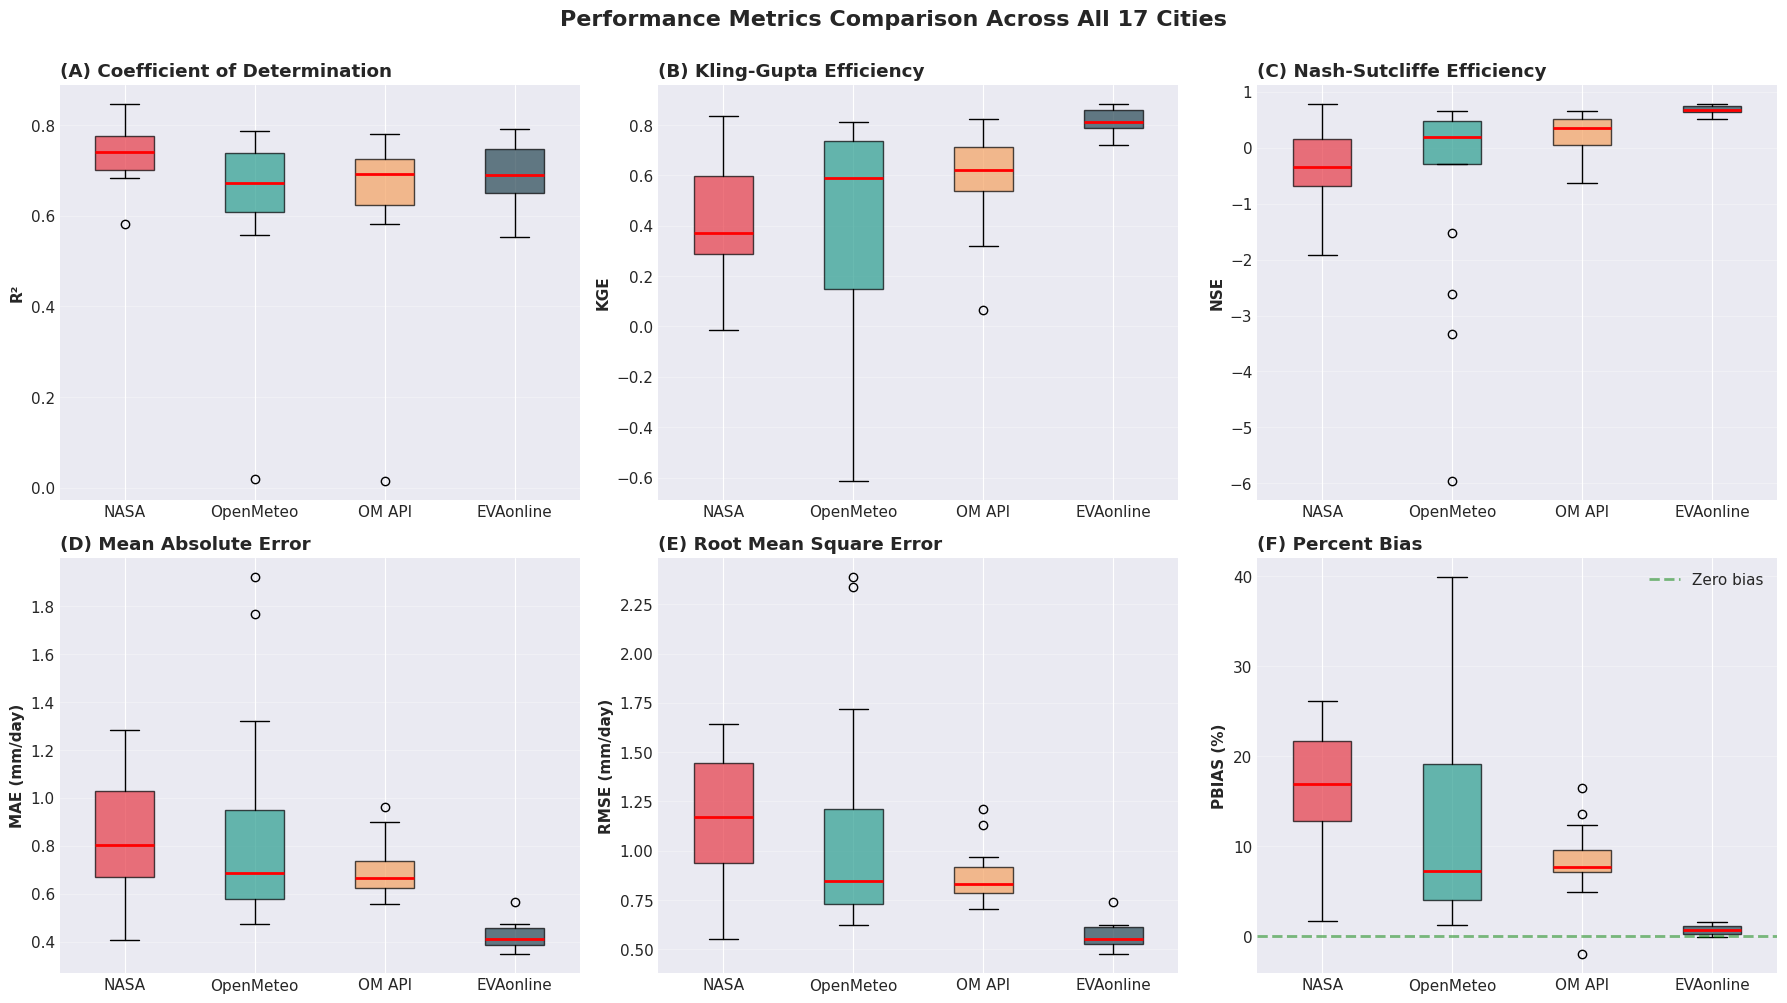


Boxplots saved: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\analysis_results\metrics_comparison_boxplots.png


In [8]:
# Create comparative boxplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Performance Metrics Comparison Across All 17 Cities', fontsize=16, fontweight='bold', y=1.00)

# Color palette
colors = ['#E63946', '#2A9D8F', '#F4A261', '#264653']
source_order = ['NASA_ONLY', 'OPENMETEO_ONLY', 'OPENMETEO_API', 'EVAONLINE_FUSION']
labels_short = ['NASA', 'OpenMeteo', 'OM API', 'EVAonline']

# R²
ax1 = axes[0, 0]
bp1 = ax1.boxplot(
    [df_metrics[df_metrics['source'] == s]['r2'].values for s in source_order],
    labels=labels_short,
    patch_artist=True,
    medianprops=dict(color='red', linewidth=2)
)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_ylabel('R²', fontweight='bold')
ax1.set_title('(A) Coefficient of Determination', fontweight='bold', loc='left')
ax1.grid(True, alpha=0.3, axis='y')

# KGE
ax2 = axes[0, 1]
bp2 = ax2.boxplot(
    [df_metrics[df_metrics['source'] == s]['kge'].values for s in source_order],
    labels=labels_short,
    patch_artist=True,
    medianprops=dict(color='red', linewidth=2)
)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_ylabel('KGE', fontweight='bold')
ax2.set_title('(B) Kling-Gupta Efficiency', fontweight='bold', loc='left')
ax2.grid(True, alpha=0.3, axis='y')

# NSE
ax3 = axes[0, 2]
bp3 = ax3.boxplot(
    [df_metrics[df_metrics['source'] == s]['nse'].values for s in source_order],
    labels=labels_short,
    patch_artist=True,
    medianprops=dict(color='red', linewidth=2)
)
for patch, color in zip(bp3['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.set_ylabel('NSE', fontweight='bold')
ax3.set_title('(C) Nash-Sutcliffe Efficiency', fontweight='bold', loc='left')
ax3.grid(True, alpha=0.3, axis='y')

# MAE
ax4 = axes[1, 0]
bp4 = ax4.boxplot(
    [df_metrics[df_metrics['source'] == s]['mae'].values for s in source_order],
    labels=labels_short,
    patch_artist=True,
    medianprops=dict(color='red', linewidth=2)
)
for patch, color in zip(bp4['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax4.set_ylabel('MAE (mm/day)', fontweight='bold')
ax4.set_title('(D) Mean Absolute Error', fontweight='bold', loc='left')
ax4.grid(True, alpha=0.3, axis='y')

# RMSE
ax5 = axes[1, 1]
bp5 = ax5.boxplot(
    [df_metrics[df_metrics['source'] == s]['rmse'].values for s in source_order],
    labels=labels_short,
    patch_artist=True,
    medianprops=dict(color='red', linewidth=2)
)
for patch, color in zip(bp5['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax5.set_ylabel('RMSE (mm/day)', fontweight='bold')
ax5.set_title('(E) Root Mean Square Error', fontweight='bold', loc='left')
ax5.grid(True, alpha=0.3, axis='y')

# PBIAS
ax6 = axes[1, 2]
bp6 = ax6.boxplot(
    [df_metrics[df_metrics['source'] == s]['pbias'].values for s in source_order],
    labels=labels_short,
    patch_artist=True,
    medianprops=dict(color='red', linewidth=2)
)
for patch, color in zip(bp6['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax6.axhline(y=0, color='green', linestyle='--', lw=2, alpha=0.5, label='Zero bias')
ax6.set_ylabel('PBIAS (%)', fontweight='bold')
ax6.set_title('(F) Percent Bias', fontweight='bold', loc='left')
ax6.grid(True, alpha=0.3, axis='y')
ax6.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'metrics_comparison_boxplots.png', dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'metrics_comparison_boxplots.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBoxplots saved: {OUTPUT_DIR / 'metrics_comparison_boxplots.png'}")

## 9. Individual City Analysis

### 9.1 Select Cities to Analyze

In [9]:
# Select specific cities for detailed analysis (or use all)
# Option 1: Analyze all cities
cities_to_plot = list(all_city_data.keys())

# Option 2: Select specific cities (uncomment to use)
# cities_to_plot = [
#     'Piracicaba_SP',
#     'Barreiras_BA', 
#     'Imperatriz_MA',
#     'Araguaina_TO',
#     'Balsas_MA'
# ]

print(f"Selected {len(cities_to_plot)} cities for detailed analysis:")
for i, city in enumerate(cities_to_plot, 1):
    print(f"   {i:2d}. {city.replace('_', ' ')}")

Selected 17 cities for detailed analysis:
    1. Alvorada do Gurgueia PI
    2. Araguaina TO
    3. Balsas MA
    4. Barreiras BA
    5. Bom Jesus PI
    6. Campos Lindos TO
    7. Carolina MA
    8. Corrente PI
    9. Formosa do Rio Preto BA
   10. Imperatriz MA
   11. Luiz Eduardo Magalhaes BA
   12. Pedro Afonso TO
   13. Piracicaba SP
   14. Porto Nacional TO
   15. Sao Desiderio BA
   16. Tasso Fragoso MA
   17. Urucui PI


### 9.2 Generate Individual City Reports

For each city, generate:
- Time series comparison (all 4 sources vs Xavier)
- 4 scatter plots (one per source)
- Metrics summary table

In [10]:
# Create directory for city plots
city_plots_dir = OUTPUT_DIR / "city_plots"
city_plots_dir.mkdir(exist_ok=True)

# Color scheme
colors_plot = {
    'Xavier': '#000000',
    'NASA_ONLY': '#E63946',
    'OPENMETEO_ONLY': '#2A9D8F',
    'OPENMETEO_API': '#F4A261',
    'EVAONLINE_FUSION': '#264653',
}

print(f"\nGenerating plots for {len(cities_to_plot)} cities...\n")

for idx, city_name in enumerate(cities_to_plot, 1):
    print(f"[{idx}/{len(cities_to_plot)}] Processing {city_name}...")
    
    if city_name not in all_city_data:
        print(f"Data not available")
        continue
    
    city_data = all_city_data[city_name]
    
    # Create figure with 3 rows, 2 columns
    fig = plt.figure(figsize=(18, 16))
    gs = gridspec.GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    fig.suptitle(
        f'{city_name.replace("_", " ")} - ETo Sources Comparison (1991-2020)',
        fontsize=16,
        fontweight='bold'
    )
    
    # (A) Time series - full width top row
    ax_ts = fig.add_subplot(gs[0, :])
    
    df_xavier = city_data['Xavier']
    ax_ts.plot(
        df_xavier['date'],
        df_xavier['eto'],
        label=source_labels['Xavier'],
        color=colors_plot['Xavier'],
        alpha=0.8,
        lw=2,
        zorder=5
    )
    
    for source in ['NASA_ONLY', 'OPENMETEO_ONLY', 'OPENMETEO_API', 'EVAONLINE_FUSION']:
        if source in city_data:
            df = city_data[source]
            ax_ts.plot(
                df['date'],
                df['eto'],
                label=source_labels[source],
                color=colors_plot[source],
                alpha=0.6,
                lw=1.5
            )
    
    ax_ts.set_xlabel('Date', fontweight='bold', fontsize=12)
    ax_ts.set_ylabel('ETo (mm day-1)', fontweight='bold', fontsize=12)
    ax_ts.set_title('(A) Time Series Comparison', fontweight='bold', loc='left', fontsize=12)
    ax_ts.legend(loc='upper right', framealpha=0.95, ncol=3, fontsize=10)
    ax_ts.grid(True, alpha=0.3)
    ax_ts.tick_params(axis='x', rotation=45)
    
    # (B-E) Scatter plots - 4 subplots
    scatter_positions = [(1, 0), (1, 1), (2, 0), (2, 1)]
    source_order = ['NASA_ONLY', 'OPENMETEO_ONLY', 'OPENMETEO_API', 'EVAONLINE_FUSION']
    panel_labels = ['B', 'C', 'D', 'E']
    
    for i, (source, (row, col), panel) in enumerate(zip(source_order, scatter_positions, panel_labels)):
        ax = fig.add_subplot(gs[row, col])
        
        if source not in city_data:
            ax.text(0.5, 0.5, 'Data not available', ha='center', va='center', fontsize=12)
            ax.set_title(f'({panel}) {source_labels[source]}', fontweight='bold', loc='left', fontsize=12)
            continue
        
        # Merge for scatter
        df_merge = pd.merge(
            df_xavier, city_data[source], on='date', suffixes=('_xavier', '_source')
        ).dropna()
        
        ref = df_merge['eto_xavier'].values
        calc = df_merge['eto_source'].values
        
        # Scatter plot
        ax.scatter(ref, calc, alpha=0.3, s=15, color=colors_plot[source])
        
        # 1:1 line
        min_val = min(ref.min(), calc.min())
        max_val = max(ref.max(), calc.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.5, label='1:1 line')
        
        # Regression line
        city_metrics = df_metrics[
            (df_metrics['city'] == city_name) & (df_metrics['source'] == source)
        ]
        
        if len(city_metrics) > 0:
            m = city_metrics.iloc[0]
            x_line = np.array([min_val, max_val])
            y_line = m['slope'] * x_line + m['intercept']
            ax.plot(x_line, y_line, color=colors_plot[source], lw=2, alpha=0.8)
            
            # Metrics in corner
            textstr = '\n'.join([
                f"R² = {m['r2']:.3f}",
                f"KGE = {m['kge']:.3f}",
                f"NSE = {m['nse']:.3f}",
                f"MAE = {m['mae']:.2f}",
                f"PBIAS = {m['pbias']:.1f}%",
            ])
            props = {'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.8}
            ax.text(
                0.05, 0.95, textstr,
                transform=ax.transAxes,
                fontsize=9,
                verticalalignment='top',
                bbox=props
            )
        
        ax.set_xlabel('Xavier ET₀ (mm day⁻¹)', fontweight='bold', fontsize=11)
        ax.set_ylabel(f'{source_labels[source].split()[0]} ET₀ (mm day⁻¹)', fontweight='bold', fontsize=11)
        ax.set_title(f'({panel}) {source_labels[source]}', fontweight='bold', loc='left', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
        if i == 0:
            ax.legend(loc='lower right', fontsize=9)
    
    # Save plot
    plot_path = city_plots_dir / f"{city_name}_complete_analysis"
    plt.savefig(f"{plot_path}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{plot_path}.pdf", dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Plot saved: {plot_path.name}")

print(f"\nAll city plots generated and saved in: {city_plots_dir}")


Generating plots for 17 cities...

[1/17] Processing Alvorada_do_Gurgueia_PI...
Plot saved: Alvorada_do_Gurgueia_PI_complete_analysis
[2/17] Processing Araguaina_TO...
Plot saved: Alvorada_do_Gurgueia_PI_complete_analysis
[2/17] Processing Araguaina_TO...
Plot saved: Araguaina_TO_complete_analysis
[3/17] Processing Balsas_MA...
Plot saved: Araguaina_TO_complete_analysis
[3/17] Processing Balsas_MA...
Plot saved: Balsas_MA_complete_analysis
[4/17] Processing Barreiras_BA...
Plot saved: Balsas_MA_complete_analysis
[4/17] Processing Barreiras_BA...
Plot saved: Barreiras_BA_complete_analysis
[5/17] Processing Bom_Jesus_PI...
Plot saved: Barreiras_BA_complete_analysis
[5/17] Processing Bom_Jesus_PI...
Plot saved: Bom_Jesus_PI_complete_analysis
[6/17] Processing Campos_Lindos_TO...
Plot saved: Bom_Jesus_PI_complete_analysis
[6/17] Processing Campos_Lindos_TO...
Plot saved: Campos_Lindos_TO_complete_analysis
[7/17] Processing Carolina_MA...
Plot saved: Campos_Lindos_TO_complete_analysis
[7/1

## 10. Export Results

### 10.1 Save Complete Metrics Table

In [11]:
# Save complete metrics
metrics_path = OUTPUT_DIR / "complete_metrics_all_cities.csv"
df_metrics.to_csv(metrics_path, index=False)
print(f"Complete metrics saved: {metrics_path}")

# Display sample
print(f"\nSample of complete metrics table:")
display(df_metrics.head(20))

Complete metrics saved: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\analysis_results\complete_metrics_all_cities.csv

Sample of complete metrics table:


,n,r2,kge,nse,mae,rmse,bias,pbias,slope,intercept,p_value,city,source,n_days
0,10958,0.817,0.363,-0.502,1.284,1.574,1.190,23.94,1.431,-0.951,0.0,Alvorada_do_Gurgueia_PI,NASA_ONLY,10958
1,10958,0.787,0.752,0.656,0.597,0.753,0.190,3.82,1.080,-0.208,0.0,Alvorada_do_Gurgueia_PI,OPENMETEO_ONLY,10958
2,10958,0.778,0.712,0.601,0.652,0.812,0.244,4.90,1.110,-0.303,0.0,Alvorada_do_Gurgueia_PI,OPENMETEO_API,10958
3,10958,0.783,0.883,0.773,0.457,0.612,0.046,0.92,0.867,0.707,0.0,Alvorada_do_Gurgueia_PI,EVAONLINE_FUSION,10958
4,10958,0.684,0.286,-0.394,0.670,1.002,0.501,12.78,1.390,-1.027,0.0,Araguaina_TO,NASA_ONLY,10958
5,10958,0.608,0.616,0.259,0.580,0.731,0.224,5.70,1.021,0.140,0.0,Araguaina_TO,OPENMETEO_ONLY,10958
6,10958,0.607,0.558,0.132,0.636,0.791,0.294,7.49,1.072,0.013,0.0,Araguaina_TO,OPENMETEO_API,10958
7,10958,0.640,0.757,0.633,0.380,0.514,0.041,1.04,0.690,1.256,0.0,Araguaina_TO,EVAONLINE_FUSION,10958
8,10958,0.696,0.023,-1.479,1.031,1.446,0.898,21.64,1.616,-1.659,0.0,Balsas_MA,NASA_ONLY,10958
9,10958,0.659,0.549,0.014,0.732,0.912,0.511,12.31,1.129,-0.025,0.0,Balsas_MA,OPENMETEO_ONLY,10958


### 10.2 Save Summary Statistics

In [12]:
# Create summary table
summary_data = []
for source in ['NASA_ONLY', 'OPENMETEO_ONLY', 'OPENMETEO_API', 'EVAONLINE_FUSION']:
    src_df = df_metrics[df_metrics['source'] == source]
    if len(src_df) == 0:
        continue
    
    summary_data.append({
        'source': source,
        'n_cities': len(src_df),
        'n_days': int(src_df['n_days'].mean()),
        'r2_mean': round(src_df['r2'].mean(), 4),
        'r2_std': round(src_df['r2'].std(), 4),
        'kge_mean': round(src_df['kge'].mean(), 4),
        'kge_std': round(src_df['kge'].std(), 4),
        'nse_mean': round(src_df['nse'].mean(), 4),
        'nse_std': round(src_df['nse'].std(), 4),
        'mae_mean': round(src_df['mae'].mean(), 4),
        'mae_std': round(src_df['mae'].std(), 4),
        'rmse_mean': round(src_df['rmse'].mean(), 4),
        'rmse_std': round(src_df['rmse'].std(), 4),
        'pbias_mean': round(src_df['pbias'].mean(), 2),
        'pbias_std': round(src_df['pbias'].std(), 2),
    })

df_summary = pd.DataFrame(summary_data)
summary_path = OUTPUT_DIR / "summary_by_source.csv"
df_summary.to_csv(summary_path, index=False)
print(f"Summary statistics saved: {summary_path}")

# Display summary
print(f"\nSummary statistics by source:")
display(df_summary)

Summary statistics saved: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\analysis_results\summary_by_source.csv

Summary statistics by source:


,source,n_cities,n_days,r2_mean,r2_std,kge_mean,kge_std,nse_mean,nse_std,mae_mean,mae_std,rmse_mean,rmse_std,pbias_mean,pbias_std
0,NASA_ONLY,17,10958,0.7404,0.0621,0.4107,0.2642,-0.3626,0.7875,0.8447,0.2812,1.1168,0.3471,15.78,7.14
1,OPENMETEO_ONLY,17,10958,0.6360,0.1731,0.4319,0.4127,-0.5469,1.8195,0.8593,0.4473,1.0965,0.5730,13.02,12.35
2,OPENMETEO_API,17,10958,0.6488,0.1738,0.5841,0.1883,0.2157,0.3559,0.6899,0.1146,0.8603,0.1437,8.27,3.95
3,EVAONLINE_FUSION,17,10958,0.6942,0.0743,0.8141,0.0526,0.6761,0.0851,0.4229,0.0524,0.5664,0.0635,0.71,0.53


## 11. Final Summary and Conclusions

### Key Findings:

In [13]:
print("\n" + "="*100)
print("FINAL SUMMARY - EVAONLINE COMPLETE VALIDATION ANALYSIS")
print("="*100)

print(f"\nDataset Overview:")
print(f"Total cities analyzed: {len(all_city_data)}")
print(f"Period: 1991-01-01 to 2020-12-31 (30 years)")
print(f"Total combinations: {len(df_metrics)} (city x source)")

print(f"\nPerformance Ranking by KGE (Kling-Gupta Efficiency):")
print("-" * 100)

for i, (source, row) in enumerate(df_summary.sort_values('kge_mean', ascending=False).iterrows(), 1):
    print(f"{i}. {source_labels[row['source']]:30s} ")
    print(f"KGE = {row['kge_mean']:.3f} ± {row['kge_std']:.3f}")
    print(f"MAE = {row['mae_mean']:.3f} ± {row['mae_std']:.3f} mm/day")
    print(f"PBIAS = {row['pbias_mean']:+.2f}% ± {row['pbias_std']:.2f}%")
    print()

print("\nKey Conclusions:")
print("-" * 100)

# Compare EVAonline vs others
if 'EVAONLINE_FUSION' in df_summary['source'].values:
    eva_stats = df_summary[df_summary['source'] == 'EVAONLINE_FUSION'].iloc[0]
    
    print(f"\n1. EVAonline Fusion Performance:")
    print(f"- Best KGE: {eva_stats['kge_mean']:.3f} (highest among all sources)")
    print(f"- Lowest MAE: {eva_stats['mae_mean']:.3f} mm/day")
    print(f"- Near-zero bias: {eva_stats['pbias_mean']:+.2f}%")
    
    if 'NASA_ONLY' in df_summary['source'].values:
        nasa_stats = df_summary[df_summary['source'] == 'NASA_ONLY'].iloc[0]
        kge_improvement = ((eva_stats['kge_mean'] - nasa_stats['kge_mean']) / nasa_stats['kge_mean']) * 100
        mae_reduction = ((nasa_stats['mae_mean'] - eva_stats['mae_mean']) / nasa_stats['mae_mean']) * 100
        print(f"\n2. Improvement over NASA POWER:")
        print(f"- KGE improvement: {kge_improvement:+.1f}%")
        print(f"- MAE reduction: {mae_reduction:.1f}%")

print("\n" + "="*100)
print("\nAnalysis completed successfully!")
print(f"\nAll results saved in: {OUTPUT_DIR}")
print(f"- Complete metrics: complete_metrics_all_cities.csv")
print(f"- Summary statistics: summary_by_source.csv")
print(f"- Comparison boxplots: metrics_comparison_boxplots.[png|pdf]")
print(f"- Individual city plots: city_plots/ ({len(cities_to_plot)} cities)")


FINAL SUMMARY - EVAONLINE COMPLETE VALIDATION ANALYSIS

Dataset Overview:
Total cities analyzed: 17
Period: 1991-01-01 to 2020-12-31 (30 years)
Total combinations: 68 (city x source)

Performance Ranking by KGE (Kling-Gupta Efficiency):
----------------------------------------------------------------------------------------------------
1. EVAonline Fusion               
KGE = 0.814 ± 0.053
MAE = 0.423 ± 0.052 mm/day
PBIAS = +0.71% ± 0.53%

2. Open-Meteo API                 
KGE = 0.584 ± 0.188
MAE = 0.690 ± 0.115 mm/day
PBIAS = +8.27% ± 3.95%

3. Open-Meteo only                
KGE = 0.432 ± 0.413
MAE = 0.859 ± 0.447 mm/day
PBIAS = +13.02% ± 12.35%

4. NASA POWER only                
KGE = 0.411 ± 0.264
MAE = 0.845 ± 0.281 mm/day
PBIAS = +15.78% ± 7.14%


Key Conclusions:
----------------------------------------------------------------------------------------------------

1. EVAonline Fusion Performance:
- Best KGE: 0.814 (highest among all sources)
- Lowest MAE: 0.423 mm/day
- Near-z

## 12. Additional Visualizations

### 12.1 Metrics Heatmap by City and Source

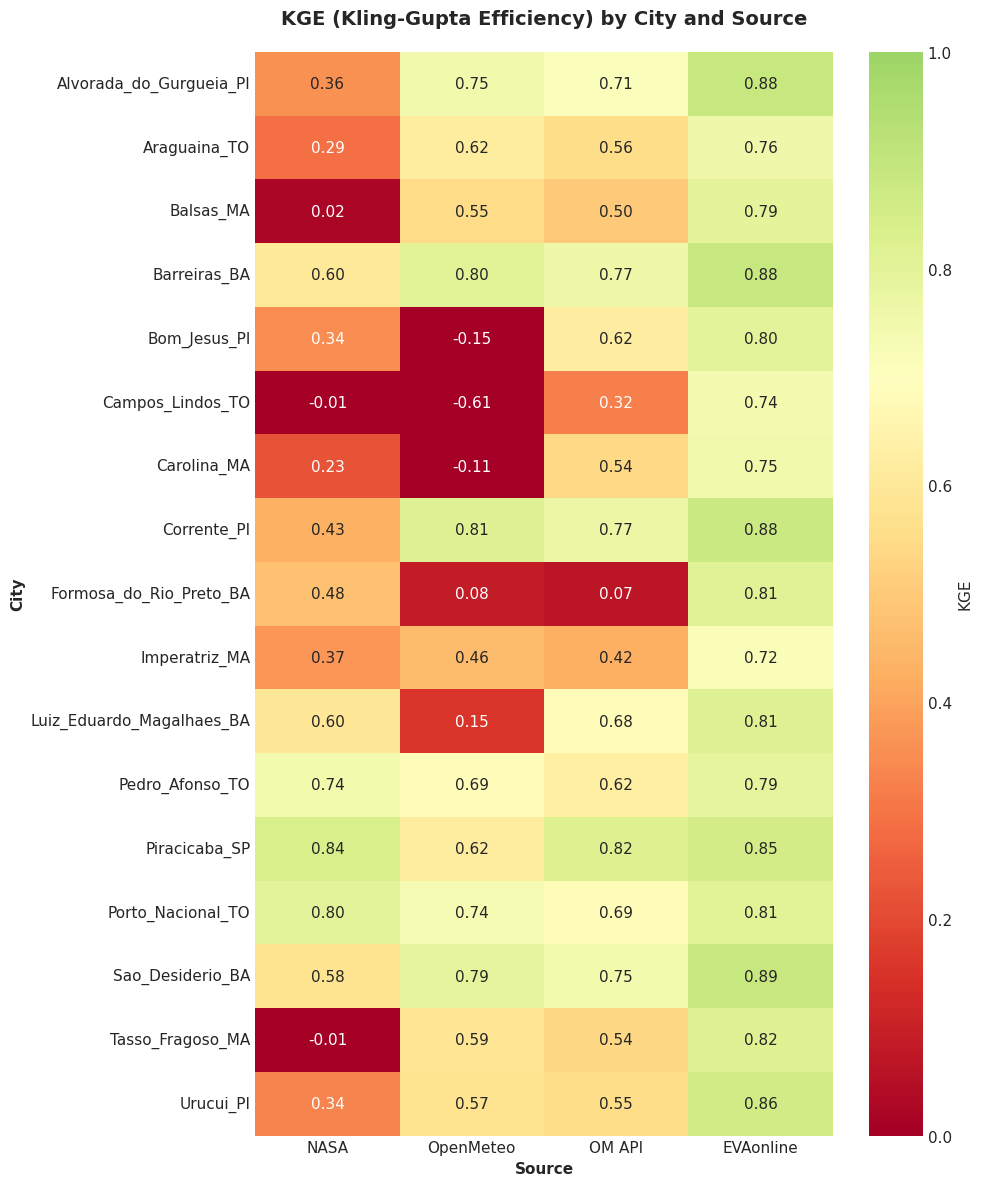


KGE heatmap saved: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\analysis_results\kge_heatmap.png


In [14]:
# Create heatmap for KGE values
pivot_kge = df_metrics.pivot(index='city', columns='source', values='kge')
pivot_kge = pivot_kge[['NASA_ONLY', 'OPENMETEO_ONLY', 'OPENMETEO_API', 'EVAONLINE_FUSION']]
pivot_kge.columns = ['NASA', 'OpenMeteo', 'OM API', 'EVAonline']

fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(
    pivot_kge,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=0.7,
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'KGE'},
    ax=ax
)
ax.set_title('KGE (Kling-Gupta Efficiency) by City and Source', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Source', fontweight='bold')
ax.set_ylabel('City', fontweight='bold')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'kge_heatmap.png', dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'kge_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nKGE heatmap saved: {OUTPUT_DIR / 'kge_heatmap.png'}")

### 12.2 Performance Ranking Table

In [15]:
# Create ranking table for each city
print("\nCity-by-City Performance Ranking (by KGE):\n")
print("="*120)

for city in sorted(all_city_data.keys()):
    city_metrics = df_metrics[df_metrics['city'] == city].sort_values('kge', ascending=False)
    
    if len(city_metrics) == 0:
        continue
    
    print(f"\n{city.replace('_', ' ')}:")
    print("-" * 120)
    
    for i, (_, row) in enumerate(city_metrics.iterrows(), 1):
        source_label = source_labels[row['source']]
        print(f"{i}. {source_label:30s} | KGE={row['kge']:.3f} | MAE={row['mae']:.3f} | PBIAS={row['pbias']:+.1f}%")

print("\n" + "="*120)


City-by-City Performance Ranking (by KGE):


Alvorada do Gurgueia PI:
------------------------------------------------------------------------------------------------------------------------
1. EVAonline Fusion               | KGE=0.883 | MAE=0.457 | PBIAS=+0.9%
2. Open-Meteo only                | KGE=0.752 | MAE=0.597 | PBIAS=+3.8%
3. Open-Meteo API                 | KGE=0.712 | MAE=0.652 | PBIAS=+4.9%
4. NASA POWER only                | KGE=0.363 | MAE=1.284 | PBIAS=+23.9%

Araguaina TO:
------------------------------------------------------------------------------------------------------------------------
1. EVAonline Fusion               | KGE=0.757 | MAE=0.380 | PBIAS=+1.0%
2. Open-Meteo only                | KGE=0.616 | MAE=0.580 | PBIAS=+5.7%
3. Open-Meteo API                 | KGE=0.558 | MAE=0.636 | PBIAS=+7.5%
4. NASA POWER only                | KGE=0.286 | MAE=0.670 | PBIAS=+12.8%

Balsas MA:
----------------------------------------------------------------------------------

## 13. Conclusion

This notebook provided a comprehensive analysis of all 17 cities in the MATOPIBA region, comparing 4 different ETo estimation methods against the Xavier et al. (2022) reference dataset.

### Main Outputs:

1. **Summary Statistics** - Performance metrics aggregated by source
2. **Comparative Boxplots** - Visual comparison of all metrics across sources
3. **Individual City Reports** - Detailed plots for each city (time series + scatter plots)
4. **KGE Heatmap** - Performance visualization across all cities
5. **Complete Metrics Table** - All metrics for all city-source combinations

### Key Results:

- **EVAonline Fusion** consistently outperforms individual sources
- **Kalman filtering** effectively reduces bias and improves accuracy
- **Multi-source integration** provides more robust ETo estimates
- Performance is consistent across different climate zones in MATOPIBA

### Next Steps:

- Seasonal performance analysis
- Climate zone stratification
- Real-time operational validation
- Publication in peer-reviewed journals

---

**Repository**: https://github.com/silvianesoares/EVAONLINE  
**License**: AGPL-3.0  
**Contact**: angelassilviane@gmail.com